# Задача классификации

In [2]:
from IPython.display import Image
Image(url='https://miro.medium.com/proxy/1*fBjniQPOKigqxYSKEumXoA.png')

# Intrusion detection learning (KDD99)
http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In [5]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [12]:
with open('../data/kddcup.names', 'r') as fd:
    line = fd.readline().strip()
    attack_types = line.split(',')
    feature_names = list()
    symbolic_feat = list()
    continuous_feat = list()
    for line in fd.readlines():
        feat_name, feat_type = line.strip().split(': ', 2)
        feature_names.append(feat_name)
        if feat_type == 'symbolic.':
            symbolic_feat.append(feat_name)
        elif feat_type == 'continuous.':
            continuous_feat.append(feat_name)
        else:
            logging.warning("Unsupported feature type: %s", feat_type)

In [15]:
ds = pd.read_csv('../data/kddcup.data_10_percent.gz', names=feature_names + ['class'])
ds.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


### Распределение объектов по классам

In [16]:
ds['class'].value_counts()

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: class, dtype: int64

### Сведение к бинерной классификации

Для простоты сведем исходную задачу к бинарной классификации. Будем относить к классу 1 все соденинения типа 'normal' и к классу 0 все остальные типы соединений

In [17]:
ds['target'] = ds['class'].map(lambda x: 1 if x == 'normal.' else 0)

### Извлечение признаков

Рассмотрим только непрерывные признаки, имена которых хранятся в массиве continuous_feat

In [18]:
X = ds[continuous_feat]
y = ds['target']

### Разделение выборки 

Для оценки качества модели разделим данные на обучающую и проверочную выборки.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Логистическая регрессия

Алгоритм классификации, который позволяет разделить признаковое пространство с помощью гиперплоскости вида
$$
\theta^Tx = 0.
$$
Здесь $\theta$ - параметры логистической регрессии.

Для оценки вероятности принадлежности к позитивному классу 1 используют логистическую функцию $\sigma(z) = \frac{1}{1 + e^{-z}}$.

Итоговая гипотеза метода логистической регресси имеет вид:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^Tx}}.
$$

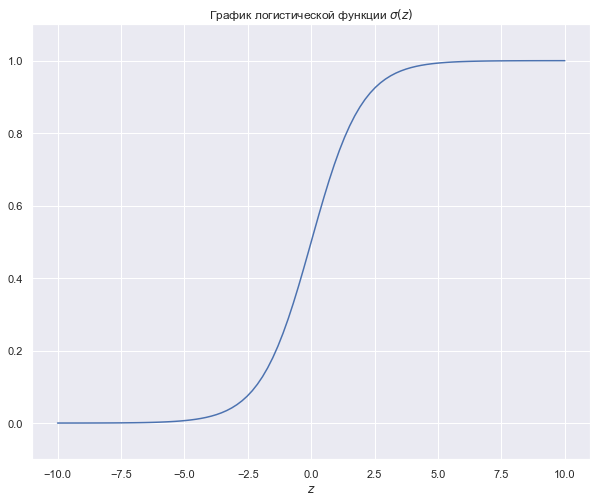

In [20]:
z = np.linspace(-10, 10, 100)
sigma = 1/(1+np.exp(-z))
plt.figure(figsize=(10,8))
plt.plot(z, sigma)
plt.ylim(-0.1, 1.1)
plt.xlabel('$z$')
plt.title('График логистической функции $\sigma(z)$');

### Обучение модели логистической регрессии

Для обучения модели будем использовать python библиотеку scikit-learn

In [22]:
%%time
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, y_train)

CPU times: user 15.5 s, sys: 799 ms, total: 16.3 s
Wall time: 9.14 s


/Users/filonov/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Метрика качесва

Будем в качестве метрики качества использовать долю правильных ответов (Accuracy). Это не самый лучший вариант для задачи бинарной классификации, но для простоты он на вполне подойдет.

In [40]:
from sklearn.metrics import accuracy_score

y_pred = logreg.predict(X_test)

logreg_acc = accuracy_score(y_test, y_pred)
print(f"LogReg accuracy = {logreg_acc:.5}")

LogReg accuracy = 0.98449


### Сохраним коэффициенты LogReg

In [28]:
coef = np.append(logreg.intercept_, logreg.coef_)
np.savetxt("logreg_coef.txt", coef)

In [29]:
!head logreg_coef.txt

3.668312795558306043e-04
4.540895296221741559e-04
-5.503563814293414949e-05
-2.951530770667293456e-07
-2.118897553002599887e-04
-5.199129061297307933e-08
-1.653263590694594668e-03
-6.659774815622030477e-06
-3.264572117158932927e-04
-4.211309330218112241e-06


### Генерируем тестовые данные для LogReg

In [30]:
X_sample = X_test.sample(10).values
y_pred_proba_logreg = logreg.predict_proba(X_sample)[:, 1].reshape(-1, 1)

np.savetxt("test_data_logreg.txt", np.hstack((y_pred_proba_logreg, X_sample)), fmt="%g")

## CatBoost

### Решающие деревья

In [32]:
Image(url="https://habrastorage.org/r/w1560/webt/kq/km/g0/kqkmg0wv7fehzmkfckw3akrf5d4.png")

### Решающий лес

In [33]:
Image(url="https://habrastorage.org/r/w1560/webt/l0/4i/ov/l04iovbmunjefjlvo5il9gytpmg.png")

### Обучение модели CatBoost

In [37]:
from catboost import CatBoostClassifier

catbst = CatBoostClassifier(iterations=20, eval_metric='Accuracy')
catbst.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Метрика качества

In [39]:
y_pred_cb = catbst.predict(X_test)
cb_acc = accuracy_score(y_test, y_pred_cb)
print(f"CatBoost accuracy: {cb_acc:.5}")

CatBoost accuracy: 0.99955


## Сохраняем модель catboost

Для хранения на диске используется собственный формат библиотеки CatBoost

In [ ]:
catbst.save_model('model.cbm', format='cpp')

: 

## Генерируем тестовые данные для CatBoost

In [42]:
X_sample = X_test.sample(10).values
y_pred_proba_logreg = catbst.predict_proba(X_sample)[:, 1].reshape(-1, 1)

np.savetxt("test_data_catboost.txt", np.hstack((y_pred_proba_logreg, X_sample)), fmt="%g")